# Implementacia nahodneho lesa

In [68]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score



from sklearn.feature_selection import RFECV
from sklearn.metrics import make_scorer, fbeta_score, f1_score
from imblearn.metrics import specificity_score


from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score


pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 50)

In [38]:
RATIOS = ['L1',
       'L2', 'L3', 'NCL_CF', 'CASH_TA', 'INV_COGS', 'CC_SAL', 'TL_COST',
       'CL_COST', 'SAL_TA', 'EQ_TA', 'EQ_TL', 'CL_CC', 'LTC_NCA', 'TZ',
       'CF_TL', 'CL_TA', 'NCL_TA', 'EBT_REV', 'ROS', 'EAT_REV', 'ROA', 'ROE',
       'CF_TA', 'CF_SAL', 'LABOR_EAT', 'LABOR_REV']

PRIMARY_VALUES = [
    'CA', 'CASH',
       'CL', 'EQ', 'NCL', 'TA', 'TL', 'CC', 'INV', 'CF_NETTO', 'CF_SELFFIN',
       'REV', 'VA', 'OE', 'EAT', 'EBIT', 'SAL', 'COST', 'INT'
]


REDUCED_FEATURE_SET = ['L1', 'L3', 'EQ_TA', 'CL_CC', 'LTC_NCA', 'TZ', 'CF_TL', 'CL_TA', 'ROS', 'ROA', 'ROE']

SKNACE_ONE_HOT = ['sknace_C', 'sknace_F', 'sknace_G', 'sknace_H', 'sknace_M', 'sknace_other']

## Priprava dat I.

In [39]:
training_raw = pd.read_csv('../../../DATA/FINAL/final/training_sample.csv')
testing_raw = pd.read_csv('../../../DATA/FINAL/final/testing_sample.csv')
training_raw.shape, testing_raw.shape

((7188, 107), (1797, 107))

In [40]:
SAL_CLASSES = training_raw['sal_class'].unique()
SKNACE_GROUPS = training_raw['sknace_division_normalized'].unique()

In [41]:
training_filled = training_raw.copy()
testing_filled = testing_raw.copy()

In [42]:

Q = training_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

control_group_ratio = 1.5

training_balanced = (
    pd.concat(
        [
            training_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q * control_group_ratio), random_state=21),
            training_filled.query('combined_issue_criteria_3y_off == 1').sample(Q, random_state=16),
        ], axis = 0
    )
)



Q_test = testing_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

testing_balanced = (
    pd.concat(
        [
            testing_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q_test * control_group_ratio), random_state=16),
            testing_filled.query('combined_issue_criteria_3y_off == 1').sample(Q_test, random_state=16),
        ], axis = 0
    )
)


X_train_balanced = training_balanced[REDUCED_FEATURE_SET].values
y_train_balanced = training_balanced['combined_issue_criteria_3y_off'].values

X_test_balanced = testing_balanced[REDUCED_FEATURE_SET].values
y_test_balanced = testing_balanced['combined_issue_criteria_3y_off'].values

X_train_imbalanced = training_filled[REDUCED_FEATURE_SET].values
y_train_imbalanced = training_filled['combined_issue_criteria_3y_off'].values

X_test_imbalanced = testing_filled[REDUCED_FEATURE_SET].values
y_test_imbalanced = testing_filled['combined_issue_criteria_3y_off'].values

X_train_valid_balanced, X_valid_valid_balanced, y_train_valid_balanced, y_valid_valid_balanced = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.2, random_state=16)


X_train_valid_imbalanced, X_valid_valid_imbalanced, y_train_valid_imbalanced, y_valid_valid_imbalanced = train_test_split(
    X_train_imbalanced, y_train_imbalanced, test_size=0.2, random_state=16)


In [43]:
print(X_train_balanced.shape, X_test_balanced.shape)
print(X_train_imbalanced.shape, X_test_imbalanced.shape)

(1750, 11) (430, 11)
(7188, 11) (1797, 11)


In [44]:
# print('\nTEST')
# print(pd.Series(y_test_balanced).value_counts())
# print(pd.Series(y_test_imbalanced).value_counts())

# print('\nTRAIN')
# print(pd.Series(y_train_balanced).value_counts())
# print(pd.Series(y_train_imbalanced).value_counts())

# print('\nTRAIN W VALID')
# print(pd.Series(y_train_valid_balanced).value_counts())
# print(pd.Series(y_train_valid_imbalanced).value_counts())

# print('\nVALID')
# print(pd.Series(y_valid_valid_balanced).value_counts())
# print(pd.Series(y_valid_valid_imbalanced).value_counts())

In [45]:
f2_scorer = make_scorer(fbeta_score, beta=2)
f3_scorer = make_scorer(fbeta_score, beta=3)

def custom_score(y_true, y_pred):
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    return 0.8 * recall + 0.2 * accuracy

custom_scorer = make_scorer(custom_score, greater_is_better=True)


def eval(real, pred, label):
    print(f'real_positives = {sum(real)}, total = {len(real)}')
    recall = recall_score(real, pred)
    accuracy = accuracy_score(real, pred)
    print(f"{label} Accuracy:", accuracy)
    print(f"{label} Precision:", precision_score(real, pred))
    print(f"{label} Recall:", recall)
    print(f"{label} Specificity:", specificity_score(real, pred))
    # print(f"{label} Balanced Accuracy:", balanced_accuracy_score(real, pred))
    print(f"{label} F1 Score:", f1_score(real, pred))
    # print(f"{label} F2 Score:", fbeta_score(real, pred, beta=2))
    # print(f"{label} Custom Scorer:", custom_score(real, pred))

    cm = confusion_matrix(real, pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(label)
    plt.show()

## Recursive feature elimination

,feature,include,ranking
1,L3,True,1
2,EQ_TA,True,1
6,CF_TL,True,1
7,CL_TA,True,1
9,ROA,True,1
10,ROE,True,1
8,ROS,False,2
4,LTC_NCA,False,3
5,TZ,False,4
3,CL_CC,False,5


real_positives = 568.0, total = 1400
Balanced train Accuracy: 0.7721428571428571
Balanced train Precision: 0.7677419354838709
Balanced train Recall: 0.6285211267605634
Balanced train Specificity: 0.8701923076923077
Balanced train F1 Score: 0.691190706679574


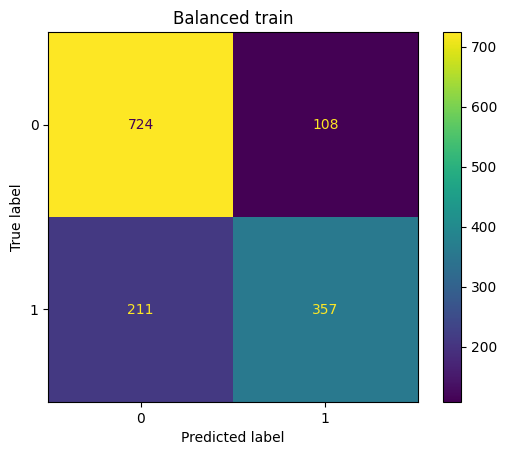

real_positives = 132.0, total = 350
Balanced test Accuracy: 0.7428571428571429
Balanced test Precision: 0.7058823529411765
Balanced test Recall: 0.5454545454545454
Balanced test Specificity: 0.8623853211009175
Balanced test F1 Score: 0.6153846153846153


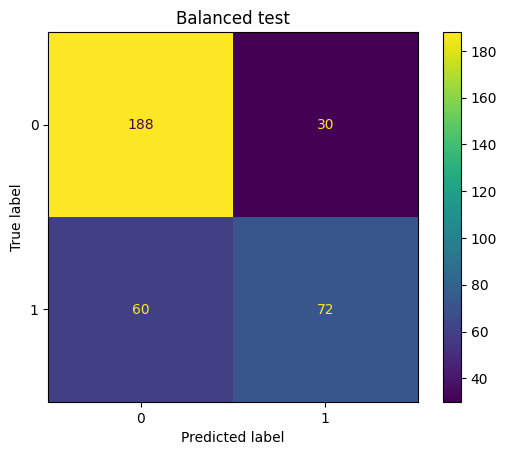

real_positives = 143.0, total = 1438
Imbalanced test Accuracy: 0.8164116828929068
Imbalanced test Precision: 0.28
Imbalanced test Recall: 0.5384615384615384
Imbalanced test Specificity: 0.8471042471042471
Imbalanced test F1 Score: 0.3684210526315789


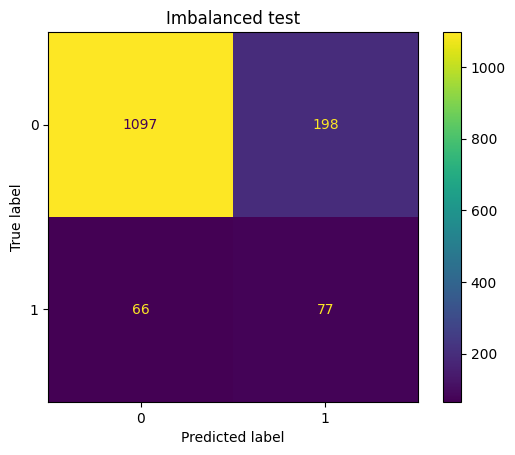

In [47]:
#
# ranking jednotlivych features pomocou RFE 
#


rf = (RandomForestClassifier(
    random_state=13,
    max_depth=  6,
    max_features= 'log2',
    min_samples_leaf= 2,
    min_samples_split= 10,
    n_estimators= 50))

rf_rfe = RFECV(estimator=rf, step=1, cv=5, scoring='f1')

rf_rfe.fit(X_train_balanced, y_train_balanced)

X_train_selected = rf_rfe.transform(X_train_valid_balanced)
X_valid_selected = rf_rfe.transform(X_valid_valid_imbalanced)
X_valid_selected_balanced = rf_rfe.transform(X_valid_valid_balanced)

rf_final = (RandomForestClassifier(
    random_state=42,
    max_depth=  4,
    max_features= 'log2',
    min_samples_leaf= 4,
    min_samples_split= 40,
    n_estimators= 40))


rf_final.fit(X_train_selected, y_train_valid_balanced)

y_pred = rf_final.predict(X_valid_selected)
y_pred_balanced = rf_final.predict(X_valid_selected_balanced)
y_pred_train = rf_final.predict(X_train_selected)

display(pd.DataFrame(zip((REDUCED_FEATURE_SET), rf_rfe.support_, rf_rfe.ranking_), columns=['feature', 'include', 'ranking']).sort_values(by='ranking', ascending=True))


eval(y_train_valid_balanced, y_pred_train, 'Balanced train')
eval(y_valid_valid_balanced, y_pred_balanced, 'Balanced test')
eval(y_valid_valid_imbalanced, y_pred, 'Imbalanced test')

In [48]:

FINAL_FEATURE_SET = list(pd.DataFrame(zip((REDUCED_FEATURE_SET), rf_rfe.support_, rf_rfe.ranking_), columns=['feature', 'include', 'ranking']).query('ranking <= 4')['feature'])
print(FINAL_FEATURE_SET)

['L3', 'EQ_TA', 'LTC_NCA', 'TZ', 'CF_TL', 'CL_TA', 'ROS', 'ROA', 'ROE']


## Priprava dat II.

In [49]:
# FINAL_FEATURE_SET = ['L3', 'EQ_TA', 'LTC_NCA', 'TZ', 'CF_TL', 'CL_TA', 'ROS', 'ROA', 'ROE']

In [51]:

Q = training_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

control_group_ratio = 1.5

training_balanced = (
    pd.concat(
        [
            training_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q * control_group_ratio)),
            training_filled.query('combined_issue_criteria_3y_off == 1').sample(Q),
        ], axis = 0
    )
)



Q_test = testing_filled.query('combined_issue_criteria_3y_off == 1')['entity_id'].nunique()

testing_balanced = (
    pd.concat(
        [
            testing_filled.query('combined_issue_criteria_3y_off == 0').sample(int(Q_test * control_group_ratio)),
            testing_filled.query('combined_issue_criteria_3y_off == 1').sample(Q_test),
        ], axis = 0
    )
)


X_train_balanced = training_balanced[FINAL_FEATURE_SET].values
y_train_balanced = training_balanced['combined_issue_criteria_3y_off'].values

X_test_balanced = testing_balanced[FINAL_FEATURE_SET].values
y_test_balanced = testing_balanced['combined_issue_criteria_3y_off'].values

X_train_imbalanced = training_filled[FINAL_FEATURE_SET].values
y_train_imbalanced = training_filled['combined_issue_criteria_3y_off'].values

X_test_imbalanced = testing_filled[FINAL_FEATURE_SET].values
y_test_imbalanced = testing_filled['combined_issue_criteria_3y_off'].values


X_train_valid_imbalanced, X_valid_valid_imbalanced, y_train_valid_imbalanced, y_valid_valid_imbalanced = train_test_split(
    X_train_imbalanced, y_train_imbalanced, test_size=0.2, random_state=42)


from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

counter = Counter(y_train_valid_imbalanced)
print(f"Original class distribution: {counter}")

minority_class_count = counter[1]
desired_majority_class_count = (minority_class_count * 3) // 2

sampling_strategy = {0: desired_majority_class_count, 1: minority_class_count}

rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_valid_balanced, y_train_valid_balanced = rus.fit_resample(X_train_valid_imbalanced, y_train_valid_imbalanced)


counter = Counter(y_valid_valid_imbalanced)
print(f"Original class distribution: {counter}")

minority_class_count = counter[1]
desired_majority_class_count = (minority_class_count * 3) // 2

sampling_strategy = {0: desired_majority_class_count, 1: minority_class_count}

rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
X_valid_valid_balanced, y_valid_valid_balanced = rus.fit_resample(X_valid_valid_imbalanced, y_valid_valid_imbalanced)


Original class distribution: Counter({0.0: 5183, 1.0: 567})
Original class distribution: Counter({0.0: 1305, 1.0: 133})


In [52]:
# print('\nTEST')
# print(pd.Series(y_test_balanced).value_counts())
# print(pd.Series(y_test_imbalanced).value_counts())

# print('\nTRAIN')
# print(pd.Series(y_train_balanced).value_counts())
# print(pd.Series(y_train_imbalanced).value_counts())

# print('\nTRAIN W VALID')
# print(pd.Series(y_train_valid_balanced).value_counts())
# print(pd.Series(y_train_valid_imbalanced).value_counts())

# print('\nVALID')
# print(pd.Series(y_valid_valid_balanced).value_counts())
# print(pd.Series(y_valid_valid_imbalanced).value_counts())

## Grid search hyper param optimization

In [56]:

# # first generation
# param_grid = {
#     'n_estimators': [10, 20, 30, 40, 50],
#     'max_depth': [None, 3, 5, 8,],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 3, 4],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'min_impurity_decrease': [0.0, 0.1, 0.01, 0.001],
#     'criterion': ['gini', 'entropy'],
# }


# second generation
# param_grid = {'max_depth': [None, 20, 25, 30],
#  'max_features': ['log2', 'sqrt'],
#  'min_samples_leaf': [2, 1, 3],
#  'min_samples_split': [20, 30, 40, 50, 60],
#  'n_estimators': [100, 80, 30, 50]}

# third generation
param_grid = {'max_depth': [20],
 'max_features': ['sqrt'],
 'min_samples_leaf': [1],
 'min_samples_split': [20, 30, 60],
 'n_estimators': [30, 40, 50] }


rf = RandomForestClassifier()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=4, verbose=10, scoring='f1')
grid_search.fit(X_train_balanced, y_train_balanced)

display(grid_search.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 60,
 'n_estimators': 50}

In [57]:

cv_results = pd.DataFrame(grid_search.cv_results_)

sorted_cv_results = cv_results.sort_values(by='rank_test_score')
sorted_cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
8,0.313223,0.019062,0.014062,0.004520,20,sqrt,1,60,50,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.666667,0.740214,0.694656,0.671378,0.708772,0.696337,0.026780,1
4,0.196629,0.017394,0.010221,0.007861,20,sqrt,1,30,40,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.654135,0.724638,0.695313,0.664286,0.704626,0.688600,0.025999,2
7,0.236012,0.017080,0.016297,0.001800,20,sqrt,1,60,40,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.666667,0.717949,0.677165,0.654804,0.706714,0.684660,0.023941,3
6,0.156224,0.017390,0.015402,0.004151,20,sqrt,1,60,30,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.653846,0.708029,0.687500,0.664234,0.704225,0.683567,0.021437,4
3,0.145324,0.009424,0.003304,0.005848,20,sqrt,1,30,30,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.666667,0.712230,0.690476,0.654545,0.692308,0.683245,0.020362,5
2,0.226976,0.016989,0.017728,0.002143,20,sqrt,1,20,50,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.664122,0.724638,0.689922,0.637363,0.696552,0.682519,0.029676,6
5,0.300125,0.042997,0.023011,0.016077,20,sqrt,1,30,50,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.669173,0.720000,0.684825,0.642336,0.692308,0.681728,0.025674,7
0,0.137926,0.006060,0.013773,0.006999,20,sqrt,1,20,30,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.664179,0.710145,0.687023,0.649819,0.684932,0.679220,0.020690,8
1,0.186686,0.011567,0.009289,0.007720,20,sqrt,1,20,40,"{'max_depth': 20, 'max_features': 'sqrt', 'min...",0.656604,0.708487,0.682353,0.617647,0.696552,0.672329,0.032348,9


In [60]:
head = cv_results.query('mean_test_score > 0.65 and std_test_score <= 0.03').sort_values(by='rank_test_score').head(8)


new_params = dict()

for param_name in ['param_max_depth', 'param_max_features', 'param_min_samples_leaf', 'param_min_samples_split', 'param_n_estimators']:
    new_params[param_name] = list(head[param_name].unique())

display(new_params)      


{'param_max_depth': [20],
 'param_max_features': ['sqrt'],
 'param_min_samples_leaf': [1],
 'param_min_samples_split': [60, 30, 20],
 'param_n_estimators': [50, 40, 30]}

## VALIDATION

In [61]:
pd.Series(y_valid_valid_imbalanced).value_counts()

0.0    1305
1.0     133
dtype: int64

In [62]:
def predict_w_threshold(estimator, X, threshold):
    proba = estimator.predict_proba(X)[:, 1]
    return (proba >= threshold).astype(int)

real_positives = 133.0, total = 332
SEMIFINAL MODEL BALANCED Accuracy: 0.7590361445783133
SEMIFINAL MODEL BALANCED Precision: 0.7054263565891473
SEMIFINAL MODEL BALANCED Recall: 0.6842105263157895
SEMIFINAL MODEL BALANCED Specificity: 0.8090452261306532
SEMIFINAL MODEL BALANCED F1 Score: 0.6946564885496184


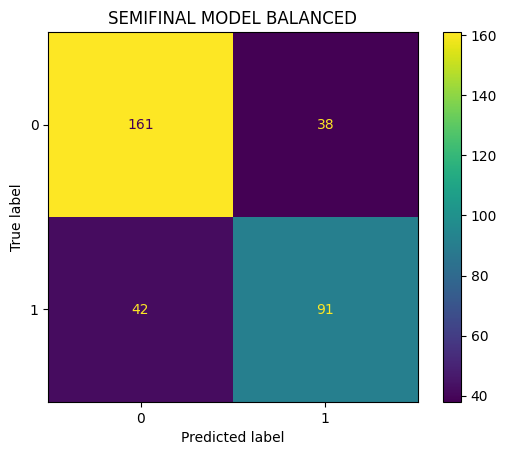

real_positives = 133.0, total = 1438
SEMIFINAL MODEL IMBALANCED Accuracy: 0.7990264255910987
SEMIFINAL MODEL IMBALANCED Precision: 0.2692307692307692
SEMIFINAL MODEL IMBALANCED Recall: 0.6842105263157895
SEMIFINAL MODEL IMBALANCED Specificity: 0.810727969348659
SEMIFINAL MODEL IMBALANCED F1 Score: 0.38641188959660294


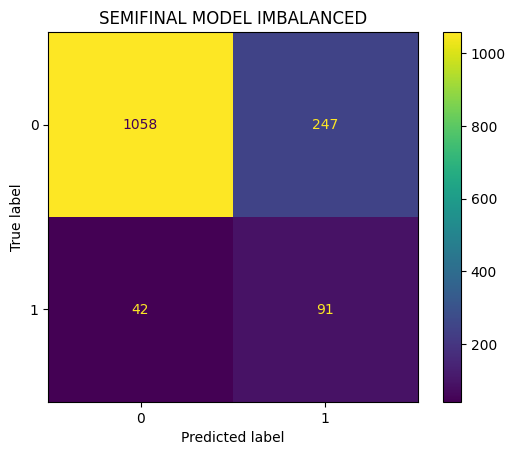

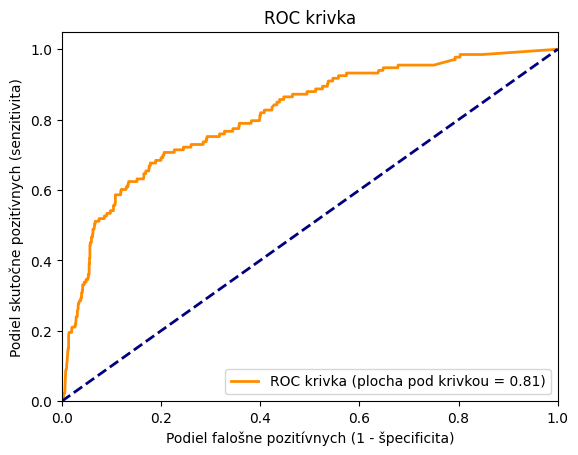

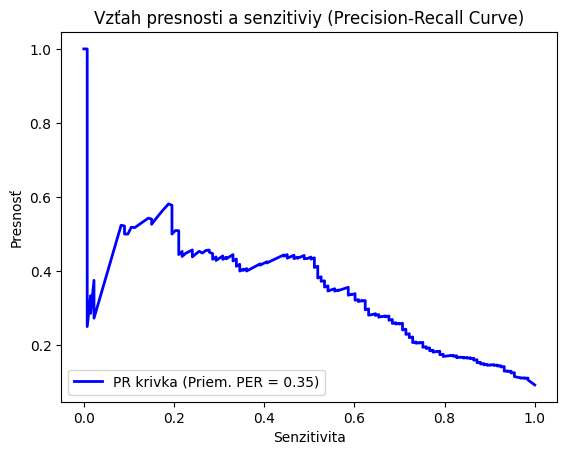

real_positives = 133.0, total = 332
FINAL MODEL IMBALANCED Accuracy: 0.7289156626506024
FINAL MODEL IMBALANCED Precision: 0.6423841059602649
FINAL MODEL IMBALANCED Recall: 0.7293233082706767
FINAL MODEL IMBALANCED Specificity: 0.7286432160804021
FINAL MODEL IMBALANCED F1 Score: 0.6830985915492958


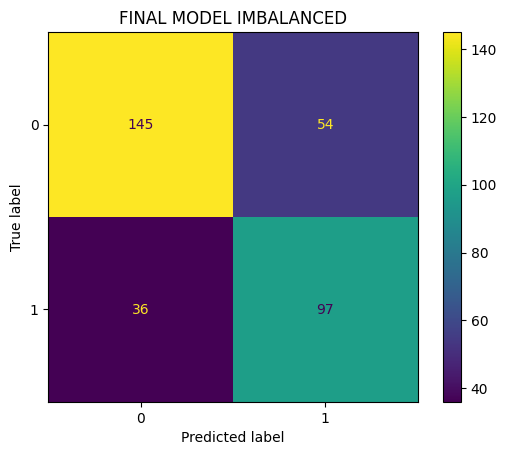

real_positives = 133.0, total = 1438
FINAL MODEL IMBALANCED Accuracy: 0.7350486787204451
FINAL MODEL IMBALANCED Precision: 0.21945701357466063
FINAL MODEL IMBALANCED Recall: 0.7293233082706767
FINAL MODEL IMBALANCED Specificity: 0.735632183908046
FINAL MODEL IMBALANCED F1 Score: 0.33739130434782605


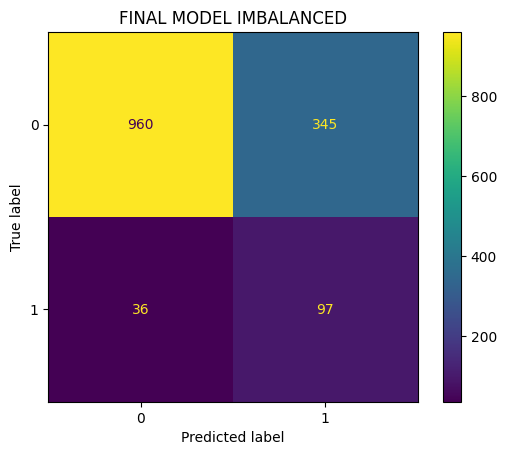

In [66]:

rf_final = (RandomForestClassifier(
    random_state=37,
    max_depth = 5,
    max_features = 'log2',
    criterion = 'gini',
    min_impurity_decrease = 0.01,
    min_samples_leaf = 2,
    min_samples_split = 5,
    n_estimators= 40))


rf_final.fit(X_train_valid_balanced, y_train_valid_balanced)

eval(y_valid_valid_balanced, rf_final.predict(X_valid_valid_balanced), 'SEMIFINAL MODEL BALANCED')
eval(y_valid_valid_imbalanced, rf_final.predict(X_valid_valid_imbalanced), 'SEMIFINAL MODEL IMBALANCED')

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score

y_probs = rf_final.predict_proba(X_valid_valid_imbalanced)[:, 1]

fpr, tpr, thresholds = roc_curve(y_valid_valid_imbalanced, y_probs)

roc_auc = roc_auc_score(y_valid_valid_imbalanced, y_probs)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivka (plocha pod krivkou = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Podiel falošne pozitívnych (1 - špecificita)')
plt.ylabel('Podiel skutočne pozitívnych (senzitivita)')
plt.title('ROC krivka')
plt.legend(loc='lower right')
plt.show()

precision, recall, thresholds = precision_recall_curve(y_valid_valid_imbalanced, y_probs)

average_precision = average_precision_score(y_valid_valid_imbalanced, y_probs)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR krivka (Priem. PER = {average_precision:.2f})')
plt.xlabel('Senzitivita')
plt.ylabel('Presnosť')
plt.title('Vzťah presnosti a senzitiviy (Precision-Recall Curve)')
plt.legend(loc='lower left')
plt.show()

eval(y_valid_valid_balanced, predict_w_threshold(rf_final, X_valid_valid_balanced, 0.4), 'FINAL MODEL IMBALANCED')
eval(y_valid_valid_imbalanced, predict_w_threshold(rf_final, X_valid_valid_imbalanced, 0.4), 'FINAL MODEL IMBALANCED')

## FINAL TESTING

real_positives = 700.0, total = 1750
FINAL MODEL TRAIN BALANCED Accuracy: 0.8137142857142857
FINAL MODEL TRAIN BALANCED Precision: 0.7876923076923077
FINAL MODEL TRAIN BALANCED Recall: 0.7314285714285714
FINAL MODEL TRAIN BALANCED Specificity: 0.8685714285714285
FINAL MODEL TRAIN BALANCED F1 Score: 0.7585185185185185


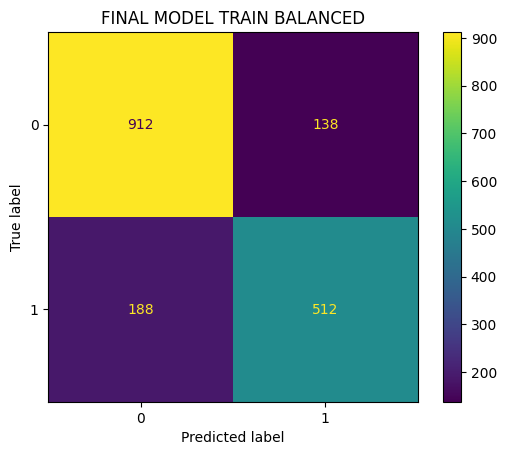

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7558139534883721
FINAL MODEL BALANCED Precision: 0.7189542483660131
FINAL MODEL BALANCED Recall: 0.6395348837209303
FINAL MODEL BALANCED Specificity: 0.8333333333333334
FINAL MODEL BALANCED F1 Score: 0.676923076923077


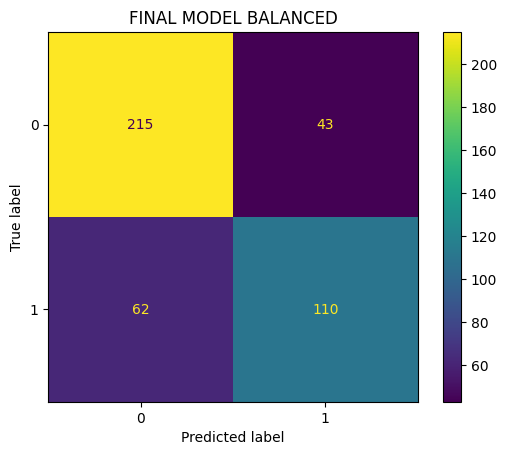

real_positives = 172.0, total = 1797
FINAL MODEL IMBALANCED Accuracy: 0.7863105175292153
FINAL MODEL IMBALANCED Precision: 0.25462962962962965
FINAL MODEL IMBALANCED Recall: 0.6395348837209303
FINAL MODEL IMBALANCED Specificity: 0.8018461538461539
FINAL MODEL IMBALANCED F1 Score: 0.36423841059602646


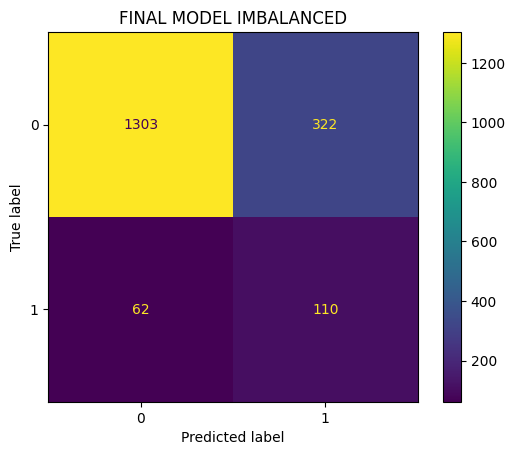

real_positives = 172.0, total = 430
FINAL MODEL BALANCED Accuracy: 0.7418604651162791
FINAL MODEL BALANCED Precision: 0.6666666666666666
FINAL MODEL BALANCED Recall: 0.7093023255813954
FINAL MODEL BALANCED Specificity: 0.7635658914728682
FINAL MODEL BALANCED F1 Score: 0.6873239436619718


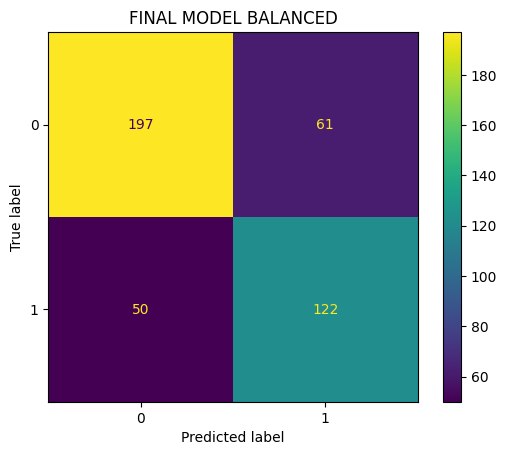

real_positives = 172.0, total = 1797
FINAL MODEL IMBALANCED Accuracy: 0.7278797996661102
FINAL MODEL IMBALANCED Precision: 0.21746880570409982
FINAL MODEL IMBALANCED Recall: 0.7093023255813954
FINAL MODEL IMBALANCED Specificity: 0.7298461538461538
FINAL MODEL IMBALANCED F1 Score: 0.3328785811732606


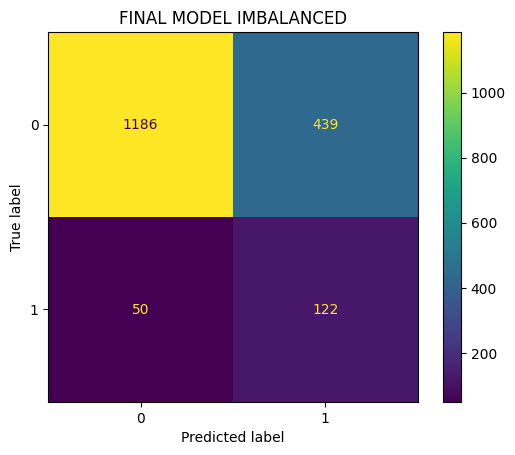

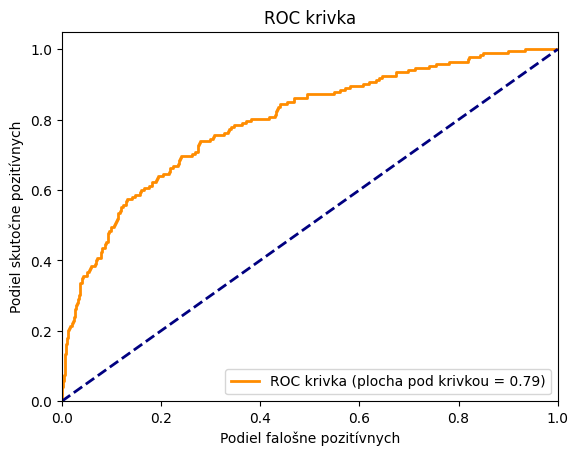

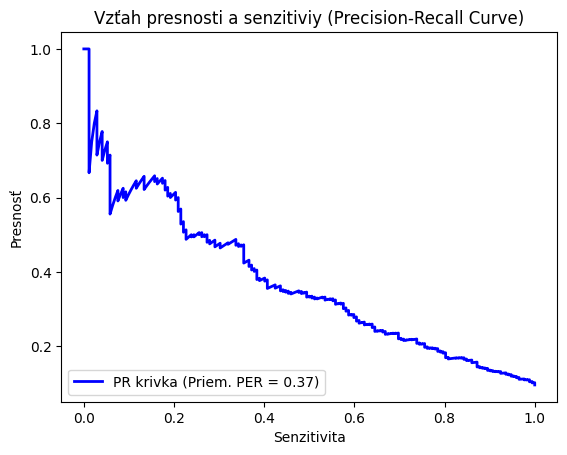

In [67]:
rf_final = (RandomForestClassifier(
    random_state=42,
    max_depth=  30,
    max_features= 'log2',
    min_samples_leaf= 2,
    min_samples_split= 50,
    n_estimators= 50))


rf_final.fit(X_train_balanced, y_train_balanced)


eval(y_train_balanced, rf_final.predict(X_train_balanced), 'FINAL MODEL TRAIN BALANCED')
eval(y_test_balanced, rf_final.predict(X_test_balanced), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, rf_final.predict(X_test_imbalanced), 'FINAL MODEL IMBALANCED')


eval(y_test_balanced,predict_w_threshold(rf_final, X_test_balanced, 0.4), 'FINAL MODEL BALANCED')
eval(y_test_imbalanced, predict_w_threshold(rf_final, X_test_imbalanced, 0.4), 'FINAL MODEL IMBALANCED')



y_probs = rf_final.predict_proba(X_test_imbalanced)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test_imbalanced, y_probs)

roc_auc = roc_auc_score(y_test_imbalanced, y_probs)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC krivka (plocha pod krivkou = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Podiel falošne pozitívnych')
plt.ylabel('Podiel skutočne pozitívnych')
plt.title('ROC krivka')
plt.legend(loc='lower right')
plt.show()

precision, recall, thresholds = precision_recall_curve(y_test_imbalanced, y_probs)

average_precision = average_precision_score(y_test_imbalanced, y_probs)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR krivka (Priem. PER = {average_precision:.2f})')
plt.xlabel('Senzitivita')
plt.ylabel('Presnosť')
plt.title('Vzťah presnosti a senzitiviy (Precision-Recall Curve)')
plt.legend(loc='lower left')
plt.show()

